# Word2Vec implementation using TensorFlow

In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
import collections
import numpy as np
import tensorflow as tf

## Configuration

In [2]:
batch_size = 20

Dimension of the embedding vector (too small to get any meaningfull embeddings, but this enables simple visualization)

In [3]:
embedding_size = 2

In [4]:
num_sampled = 15 # Number of negative examples to sample

## Sample sentences

In [5]:
sentences = ["the quick brown fox jumped over the lazy dog",
             "I love cats and dogs",
             "we all love cats and dogs",
             "cats and dogs are great",
             "sung likes cats",
             "she loves dogs",
             "cats can be very independent",
             "cats are great companions when they want to be",
             "cats are playful",
             "cats are natural hunters",
             "It's raining cats and dogs",
             "dogs and cats love sung"]

## Sentences to words

In [6]:
words = ' '.join(sentences).strip().split()

## Build dictionaries

In [7]:
idx2word = list(set(words))
word2idx = {w: i for i, w in enumerate(idx2word)}

In [8]:
voc_size = len(idx2word)

## Make indexed word data

In [9]:
data = [word2idx[w] for w in words]

data[:10]

[8, 21, 26, 20, 25, 1, 8, 31, 24, 30]

## Make training data for window size 1
(for simplicity)

### CBOW pairs

In [10]:
cbow_pairs = []
for i in range(1, len(data) - 1):
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]])
    
cbow_pairs[:10]

[[[8, 26], 21],
 [[21, 20], 26],
 [[26, 25], 20],
 [[20, 1], 25],
 [[25, 8], 1],
 [[1, 31], 8],
 [[8, 24], 31],
 [[31, 30], 24],
 [[24, 10], 30],
 [[30, 9], 10]]

### Skip-Gram pairs

In [11]:
skip_gram_pairs = []
for c in cbow_pairs:
    skip_gram_pairs.append([c[1], c[0][0]])
    skip_gram_pairs.append([c[1], c[0][1]])

skip_gram_pairs[:10]

[[21, 8],
 [21, 26],
 [26, 21],
 [26, 20],
 [20, 26],
 [20, 25],
 [25, 20],
 [25, 1],
 [1, 25],
 [1, 8]]

## Generate batches

In [12]:
def generate_batch(size):
    assert size < len(skip_gram_pairs)
    r = np.random.choice(range(len(skip_gram_pairs)), size, replace=False)
    x_data = np.array([skip_gram_pairs[i][0] for i in r], np.int32)
    y_data = np.array([[skip_gram_pairs[i][1]] for i in r], np.int32)
    
    return x_data, y_data

In [13]:
generate_batch(3)

(array([23,  2, 26], dtype=int32), array([[29],
        [34],
        [21]], dtype=int32))

## Input data

In [14]:
x = tf.placeholder(tf.int32, shape=[batch_size])
y = tf.placeholder(tf.int32, shape=[batch_size, 1]) # need this shape for nce_loss

## Ops and variables
Pinned to CPU because of missing GPU implementation

In [15]:
with tf.device('/cpu:0'):
    # Look up embeddings for inputs
    embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
    # Lookup table
    embed = tf.nn.embedding_lookup(embeddings, x)

## Construct variables for Noise-Contrastive Estimation loss

In [16]:
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))

In [17]:
nce_biases = tf.Variable(tf.zeros([voc_size]))

## Compute average NCE loss for batch

In [18]:
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, embed, y, num_sampled, voc_size))

It automatically draws negative samples when we evaluate loss.

## Use Adam optimizer

In [19]:
optimizer = tf.train.AdamOptimizer(1e-1).minimize(loss)

## Launch the graph in a session

In [20]:
init = tf.initialize_all_variables()

In [21]:
with tf.Session() as sess:
    # Initializing all variables
    sess.run(init)
    
    for step in range(100):
        batch_inputs, batch_labels = generate_batch(batch_size)
        
        _, loss_val = sess.run([optimizer, loss],
                               feed_dict={x: batch_inputs, y: batch_labels})
        
        if step % 10 == 0:
            print("Loss at {}: {}".format(step, loss_val))
    
    # Final embeddings are now ready for use (just needing normalization)
    trained_embedddings = embeddings.eval()

Loss at 0: 18.1395263671875
Loss at 10: 10.34326457977295
Loss at 20: 9.011579513549805
Loss at 30: 6.034790992736816
Loss at 40: 4.927628993988037
Loss at 50: 3.2432684898376465
Loss at 60: 3.4420838356018066
Loss at 70: 3.1797406673431396
Loss at 80: 3.106839656829834
Loss at 90: 3.722137451171875


## Visualization

(one common method for dimensionality reduction is [t-SNE](https://lvdmaaten.github.io/tsne/))

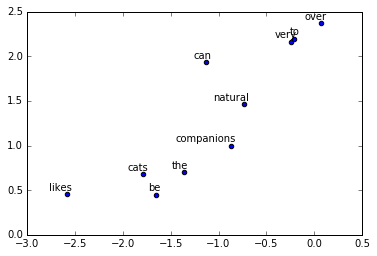

In [22]:
if trained_embedddings.shape[1] == 2:
    labels = idx2word[:10]
    for i, label in enumerate(labels):
        x, y = trained_embedddings[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()